# 0.0 IMPORTS

In [114]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16  # ou outra arquitetura de CNN
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import seaborn as sns
import cv2
import imutils

from functools import partial


## Helper Functions

In [120]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [116]:
tf.keras.backend.clear_session()

In [117]:
data_dir = 'C:/Users/edils/repos/brain_tumor_detection/data/'

filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [118]:
X_train, X_val = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
X_train, X_test = train_test_split(X_train, test_size=0.1, shuffle=True, random_state=42)

In [119]:
X_train_crop = crop_imgs(set_name=X_train)

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [96]:
#image size
batch_size=32
img_size = (224,224)
channels=3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True)

ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(X_train, 
                                       x_col='filepaths', 
                                       y_col='labels',
                                       rescale=1./255,
                                       target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       shuffle=True,
                                       batch_size=batch_size)

val_gen = tr_gen.flow_from_dataframe(X_val, 
                                       x_col='filepaths', 
                                       y_col='labels',
                                       rescale=1./255,
                                       target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       shuffle=True,
                                       batch_size=batch_size)

test_gen = tr_gen.flow_from_dataframe(X_test, 
                                       x_col='filepaths', 
                                       y_col='labels',
                                       rescale=1./255,
                                       target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       shuffle=False,
                                       batch_size=batch_size)

Found 181 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Found 21 validated image filenames belonging to 2 classes.


ValueError: num must be an integer with 1 <= num <= 16, not 17

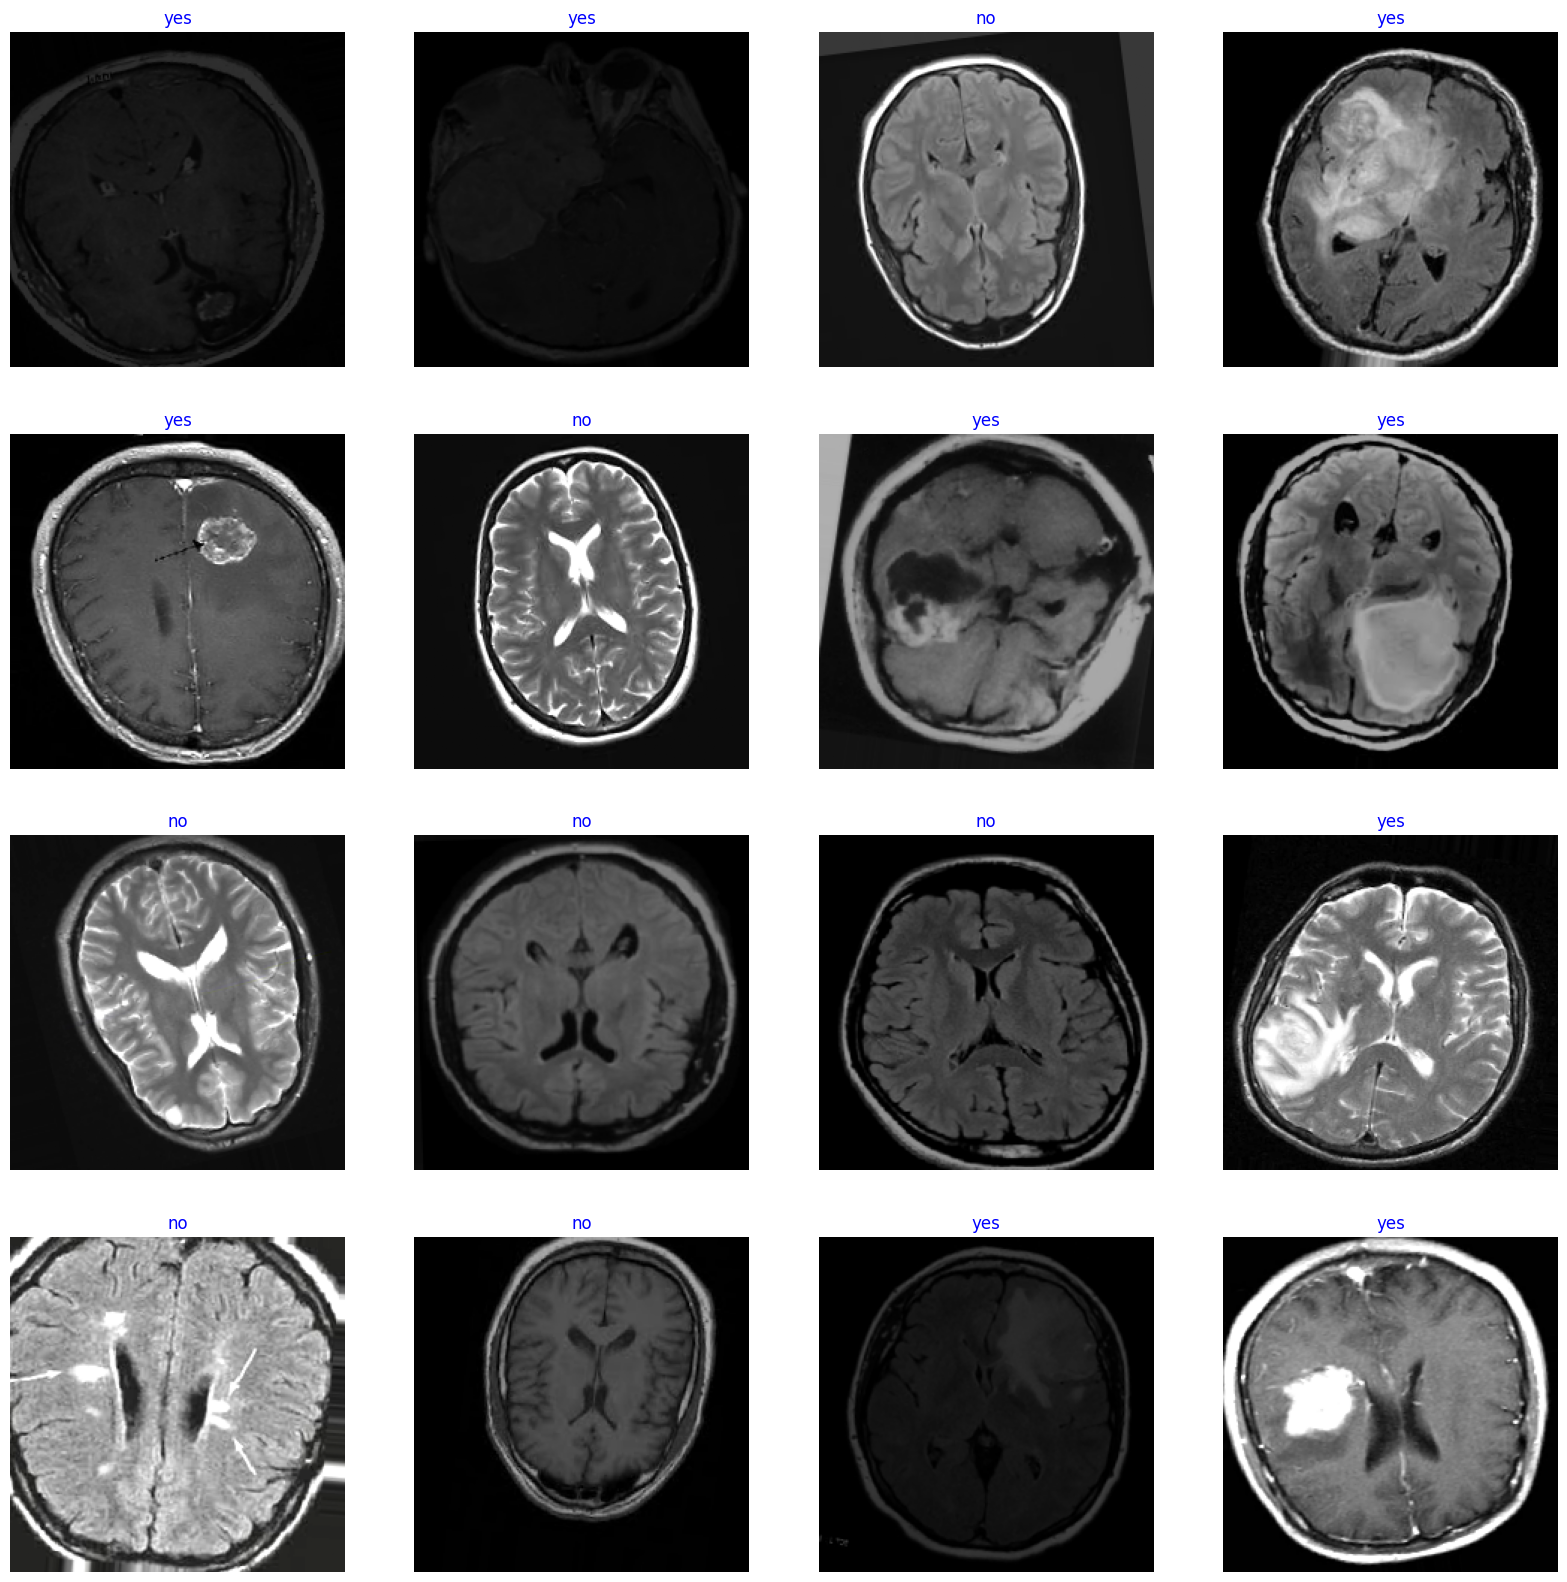

In [98]:
#Show sample data
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(32):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [99]:
# DefaultConv2D = partial(tf.keras.layers.Conv2D, 
#                         kernel_size=3, 
#                         padding='same', 
#                         activation='relu',
#                         kernel_initializer='he_normal')

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Rescaling(1/255, input_shape=(224,224,3)),
#     DefaultConv2D(filters=64, kernel_size=7),
#     tf.keras.layers.MaxPool2D(),
#     DefaultConv2D(filters=128),
#     DefaultConv2D(filters=128),
#     tf.keras.layers.MaxPool2D(),
#     DefaultConv2D(filters=256),
#     DefaultConv2D(filters=256),
#     tf.keras.layers.MaxPool2D(),
    
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(units=128,
#                           activation='relu',
#                           kernel_initializer='he_normal'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(units=64,
#                           activation='relu',
#                           kernel_initializer='he_normal'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(units=2, activation='softmax')
# ])

def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1/255, input_shape=(224, 224, 3)),
        tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')  # Alteração na camada de saída
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',  # Alteração na função de perda
                  metrics=['accuracy'])
    return model

In [100]:
model = create_model()

In [101]:
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [102]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 93312)             0

In [103]:
epochs=30
batch_size=8
early_stopping = EarlyStopping(
                monitor='val_accuracy', 
                mode='max',
                patience=5,
                restore_best_weights=True
)


history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[early_stopping])

Epoch 1/30
6/6 [==============================] - 4s 645ms/step - loss: 0.9008 - accuracy: 0.5912 - val_loss: 0.6375 - val_accuracy: 0.6078
Epoch 2/30
6/6 [==============================] - 3s 556ms/step - loss: 0.6546 - accuracy: 0.6685 - val_loss: 0.6488 - val_accuracy: 0.6078
Epoch 3/30
6/6 [==============================] - 3s 535ms/step - loss: 0.6312 - accuracy: 0.6077 - val_loss: 0.5957 - val_accuracy: 0.6275
Epoch 4/30
6/6 [==============================] - 3s 525ms/step - loss: 0.6193 - accuracy: 0.6298 - val_loss: 0.5667 - val_accuracy: 0.7255
Epoch 5/30
6/6 [==============================] - 3s 536ms/step - loss: 0.5982 - accuracy: 0.7072 - val_loss: 0.5272 - val_accuracy: 0.8039
Epoch 6/30
6/6 [==============================] - 3s 570ms/step - loss: 0.5747 - accuracy: 0.7459 - val_loss: 0.4828 - val_accuracy: 0.8039
Epoch 7/30
6/6 [==============================] - 3s 561ms/step - loss: 0.5993 - accuracy: 0.7182 - val_loss: 0.4630 - val_accuracy: 0.8235
Epoch 8/30
6/6 [====

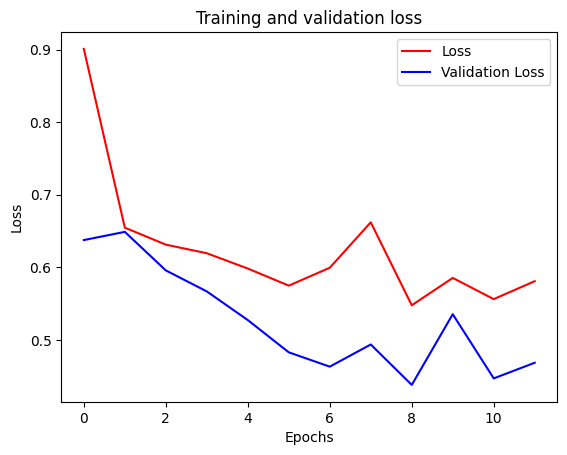

In [105]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs =[*range(12)]

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

In [106]:
model.evaluate(test_gen)

1/1 [==============================] - 0s 221ms/step - loss: 0.5290 - accuracy: 0.6667


[0.5289791226387024, 0.6666666865348816]

In [107]:
y_pred = model.predict(test_gen)

1/1 [==============================] - 0s 255ms/step


In [108]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.labels
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

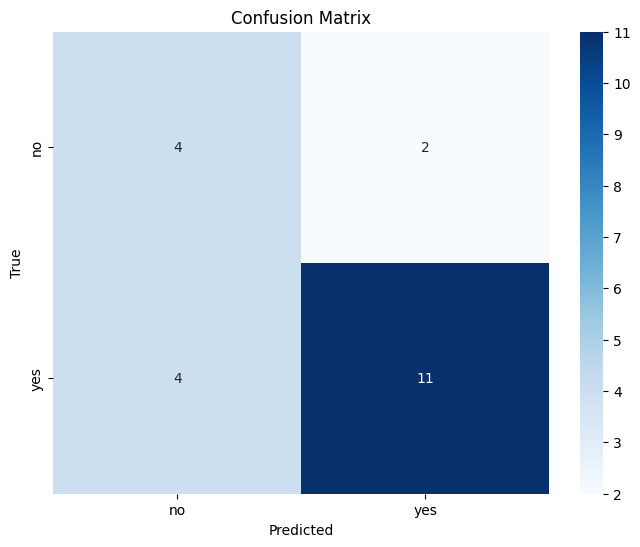

In [109]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()